In [13]:
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
import pymysql
import pandas as pd
import numpy as np
import re

In [14]:
# 생성 모델은 Generator와 Discriminator가 결합된 GAN 모델 학습 시에 학습되고,
# 가짜 Data를 만드는 과정에서 사용된다.
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# 분별 모델은 진짜 데이터의 Target값을 1로, 가짜 데이터의 Target값을 0으로 하여 학습 시킨다
# 학습된 모델은 GAN모델에서 생성자와 결합된다.
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# 분별자는 따로 학습되고 있어 가중치를 업데이트 하지 않는다 (판별용으로만 사용)
# GAN 모델에서는 생성자의 가중치만 업데이트 한다.
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [15]:
# 실제 데이터를 생성해 내는 부분 (X, X^2)의 값을 만들고 실제 데이터이므로 Target 값은 True로 둔다
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y
    
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# 가짜 데이터를 만드는 부분. GAN에서 학습되는 Generator로 가공의 값을 만들고
# Target은 가짜이므로 False로 둔다
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	y = zeros((n, 1))
	return X,y

In [16]:
# 분별자 학습
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)
        
# GAN 모델 학습
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

1999 0.5400000214576721 0.0


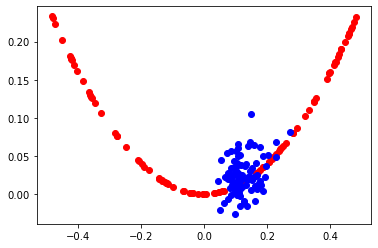

In [ ]:
# 중간의 결과를 보여주는 부분으로 실제 데이터와 가짜 데이터를 임의로 하나씩 생성해 내어 분별자로 해당 데이터가 
# 얼마나 진짜와 가까운 지(accuracy)를 출력하고 차트에 생성된 데이터를 표시함
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()


def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# 실제 데이터를 생성하고
		x_real, y_real = generate_real_samples(half_batch)
		# 가짜 데이터는 Generator의 Predict로 만들어 낸다
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# 분별자(discriminator)를 생성한 데이터로 학습하고
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# GAN모델을 통해 Generator를 학습 시킨다.
		gan_model.train_on_batch(x_gan, y_gan)
		# 중간의 결과물들을 출력
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
            
# 함수를 호출해 모델을 정의하고 train 실행
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim)